## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
# mount google drive to load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# colab google drive path
import sys
sys.path.append('drive/MyDrive/02516 IDLCV')

In [35]:
import os
import glob
import random
import numpy as np
from tqdm.notebook import tqdm
from typing import Dict, Tuple
from pathlib import Path

from data_loader import Hotdog_NotHotdog
from plot_smothgrad import plot_smoothgrad_saliency_map

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

In [36]:
# check device (cpu or gpu or mps)
def get_device() -> torch.device:
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    print("The code will run on CPU.")
    return torch.device("cpu")

In [37]:
# set seed
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True

In [60]:
# initialize parameters

data_path="./drive/MyDrive/02516 IDLCV/hotdog_nothotdog"
batch_size=64
IMG = 224
num_workers=4
epochs=20
device = get_device()

# calculate by Calc_Mean_and_Std.ipynb
TRAINSET_MEAN = [0.5424422025680542, 0.4435988962650299, 0.3444126844406128]
TRAINSET_STD = [0.26526492834091187, 0.2597216069698334, 0.2690683901309967]

EVALSET_MEAN = [0.543861448764801, 0.4478202760219574, 0.3497999906539917]
EVALSET_STD = [0.263683021068573, 0.25815925002098083, 0.26918601989746094]

seed_everything()

In [39]:
# data augmentation transforms

base_tfms_list = [transforms.RandomResizedCrop(IMG, scale=(1.0,1.0), antialias=True)]
common_trainset_tfms_list = [transforms.ToTensor(), transforms.Normalize(TRAINSET_MEAN, TRAINSET_STD)]

eval_tfms = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(IMG),
    transforms.ToTensor(),
    transforms.Normalize(EVALSET_MEAN, EVALSET_STD),
])

train_tfms = {
    "Baseline": transforms.Compose(base_tfms_list + common_trainset_tfms_list),
    "G_hflip": transforms.Compose(base_tfms_list + [
        transforms.RandomHorizontalFlip(0.5)
    ] + common_trainset_tfms_list),
    "G_rot": transforms.Compose(base_tfms_list + [
        transforms.RandomRotation(10, fill=0)
    ] + common_trainset_tfms_list),
    "P_light": transforms.Compose(base_tfms_list + [
        transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.15,0.03)], p=0.4)
    ] + common_trainset_tfms_list),
    "P_med": transforms.Compose(base_tfms_list + [
        transforms.RandomApply([transforms.ColorJitter(0.3,0.3,0.3,0.08)], p=0.6)
    ] + common_trainset_tfms_list),
    "G_gaussian_blur": transforms.Compose(base_tfms_list + [
        transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2.0))
    ] + common_trainset_tfms_list),
    "R_erasing": transforms.Compose(base_tfms_list + [
        transforms.RandomHorizontalFlip(0.5)
    ] + common_trainset_tfms_list + [
        transforms.RandomErasing(p=0.1, scale=(0.02,0.12), ratio=(0.3,3.3), inplace=False)
    ]),
    "G_hflip_P_light_R_erasing": transforms.Compose(base_tfms_list + [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.15,0.03)], p=0.4),
    ] + common_trainset_tfms_list + [
        transforms.RandomErasing(p=0.1, scale=(0.02,0.12), ratio=(0.3,3.3), inplace=False)
    ]),
    "A_autoaugment": transforms.Compose([
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(IMG),
    ] + common_trainset_tfms_list),
    "A_randaugment": transforms.Compose([
        transforms.RandAugment(num_ops=2, magnitude=9),
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(IMG),
    ] + common_trainset_tfms_list),
}

In [40]:
# load raw dataset (no transform)
raw_trainset = Hotdog_NotHotdog(train=True, transform=None, data_path=data_path)
raw_evalset = Hotdog_NotHotdog(train=False, transform=None, data_path=data_path)

raw_train_loader = DataLoader(raw_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
raw_val_loader = DataLoader(raw_evalset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

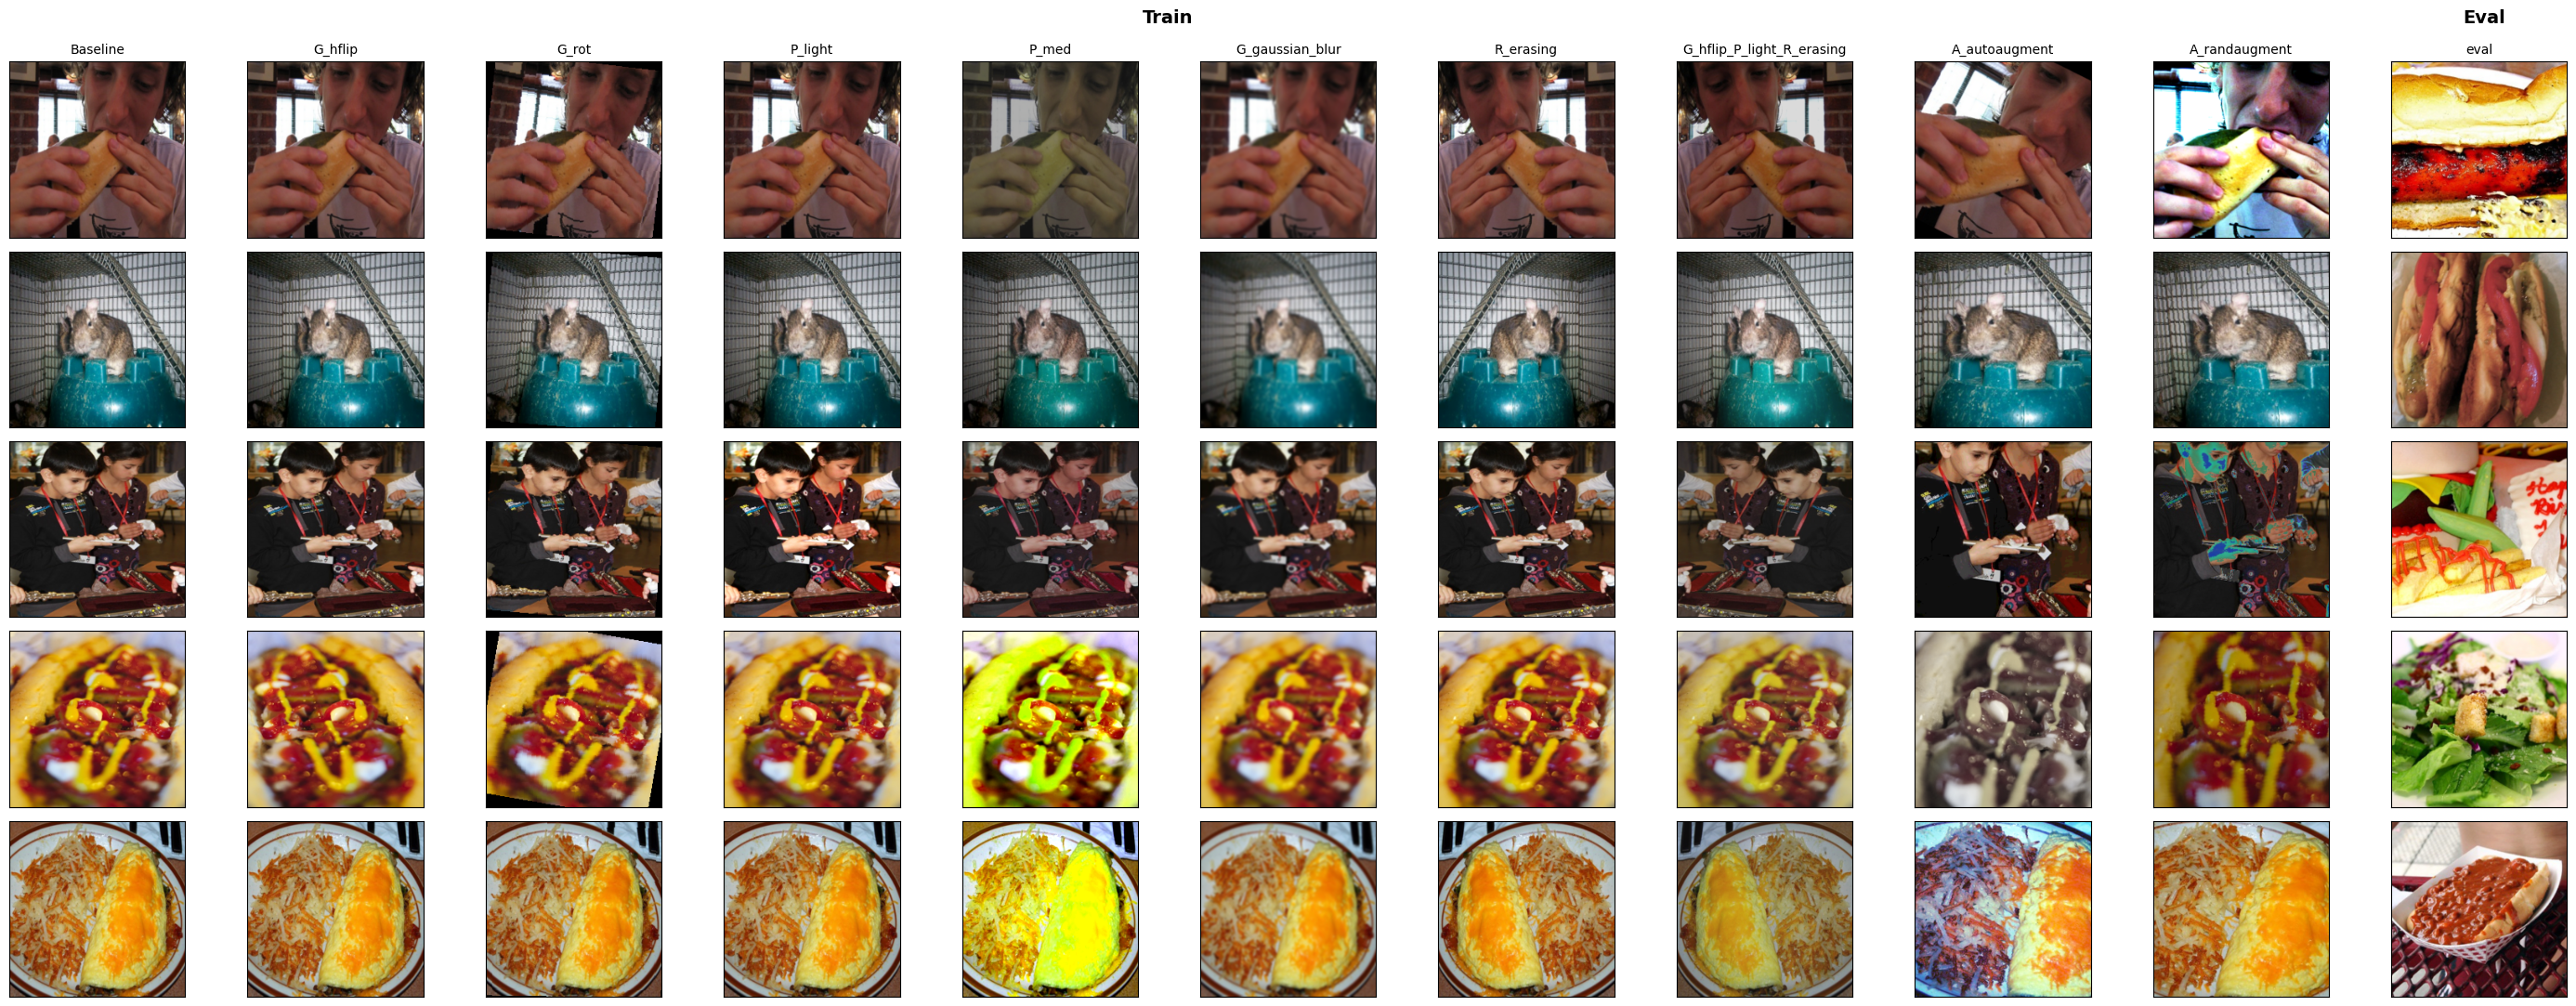

In [8]:
def show_train_eval_grid(raw_trainset, raw_evalset, train_tfms: dict, eval_tfms: object, instance_size: int = 3):
    """
    Visualize multiple training transformations vs a single eval transform.
    - Left block: each column is a train transform from `train_tfms` (dict key used as column title)
    - Right block: single 'eval' column using `eval_tfms`
    - Rows: same original images (length = instance_size)

    Assumes images are in an ImageFolder at DATA_ROOT ('data/train'). Change DATA_ROOT if needed.
    """
    # --- config you can tweak ---

    # seed_everything()

    # --- helper: find Normalize(mean,std) inside a composed transform (if any) ---
    def find_norm(tfm):
        if hasattr(tfm, 'transforms'):  # likely a Compose
            for t in tfm.transforms:
                if isinstance(t, transforms.Normalize):
                    return torch.tensor(t.mean)[:, None, None], torch.tensor(t.std)[:, None, None]
        if isinstance(tfm, transforms.Normalize):
            return torch.tensor(tfm.mean)[:, None, None], torch.tensor(tfm.std)[:, None, None]
        return None, None  # not found

    # --- helper: apply a transform to a PIL image and de-normalize for display if needed ---
    def apply_and_to_numpy(pil_img, tfm):
        x = tfm(pil_img)  # typically tensor CHW, possibly normalized
        if isinstance(x, torch.Tensor) and x.ndim == 3:
            mean, std = find_norm(tfm)
            if mean is not None and std is not None:
                x = x * std + mean
            x = x.clamp(0, 1)
            return x.permute(1, 2, 0).detach().cpu().numpy()  # HWC float in [0,1]
        # If a pipeline returns PIL (rare here), convert to np
        try:
            return np.asarray(x)
        except Exception:
            # last resort: return the original PIL
            return np.asarray(pil_img)



    if len(raw_trainset) < instance_size or len(raw_evalset) < instance_size:
        raise ValueError(f"Need at least {instance_size} images in {data_path} (found raw_trainset={len(raw_trainset)} and raw_evalset={len(raw_evalset)}).")

    # sample images separately from train and eval
    idxs_train = random.sample(range(len(raw_trainset)), instance_size)
    idxs_eval  = random.sample(range(len(raw_evalset)), instance_size)

    # columns: all train tfms + 1 eval col
    col_names = list(train_tfms.keys()) + ["eval"]
    col_tfms  = list(train_tfms.values()) + [eval_tfms]
    n_rows, n_cols = instance_size, len(col_tfms)

    # --- figure ---
    fig_w = max(2.6 * n_cols, 3.5)
    fig_h = max(2.2 * n_rows, 3.5)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    # headers
    train_cols = len(train_tfms)
    if train_cols > 0:
        x_center_train = train_cols / (n_cols * 2)
        fig.text(x_center_train, 0.98, "Train",
                 ha="center", va="top", fontsize=14, fontweight="bold")
    fig.text((train_cols + 0.45)/ n_cols, 0.98, "Eval",
             ha="center", va="top", fontsize=14, fontweight="bold")

    # column titles
    for c, name in enumerate(col_names):
        axes[0, c].set_title(name, fontsize=10)

    # fill train columns
    for r, idx in enumerate(idxs_train):
        pil_img, _ = raw_trainset[idx]
        for c, tfm in enumerate(list(train_tfms.values())):
            ax = axes[r, c]
            img_np = apply_and_to_numpy(pil_img, tfm)
            ax.imshow(img_np)
            ax.set_xticks([]); ax.set_yticks([])

    # fill eval column (last one)
    for r, idx in enumerate(idxs_eval):
        pil_img, _ = raw_evalset[idx]
        ax = axes[r, -1]
        img_np = apply_and_to_numpy(pil_img, eval_tfms)
        ax.imshow(img_np)
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


show_train_eval_grid(raw_trainset, raw_evalset, train_tfms=train_tfms, eval_tfms=eval_tfms, instance_size=5)

In [45]:
def show_images(dataset, instance_size):
    idxs = random.sample(range(len(dataset)), instance_size)
    plt.figure(figsize=(20, 10))

    for r, idx in enumerate(idxs):
        img, label = dataset[idx]

        # Convert to numpy correctly
        if isinstance(img, torch.Tensor):        # CHW tensor
            img_np = np.transpose(img.cpu().numpy(), (1,2,0))
        else:                                    # PIL image
            img_np = np.array(img)

        plt.subplot(1, instance_size, r+1)  # 1 row of images
        plt.imshow(img_np)
        plt.title(['hotdog', 'not hotdog'][label])
        plt.axis('off')

    plt.show()

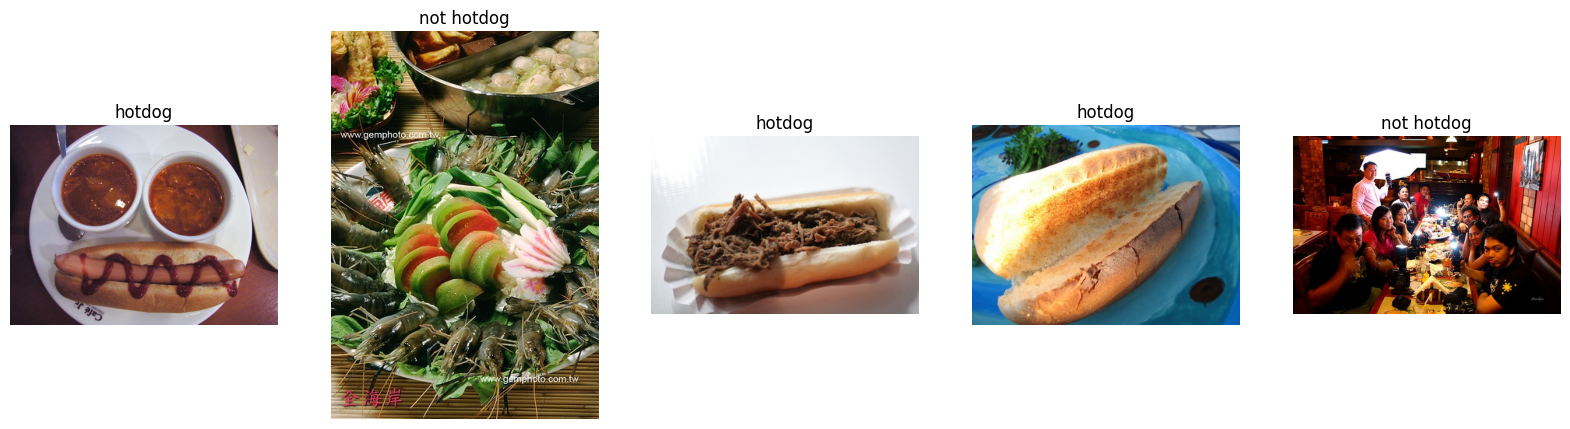

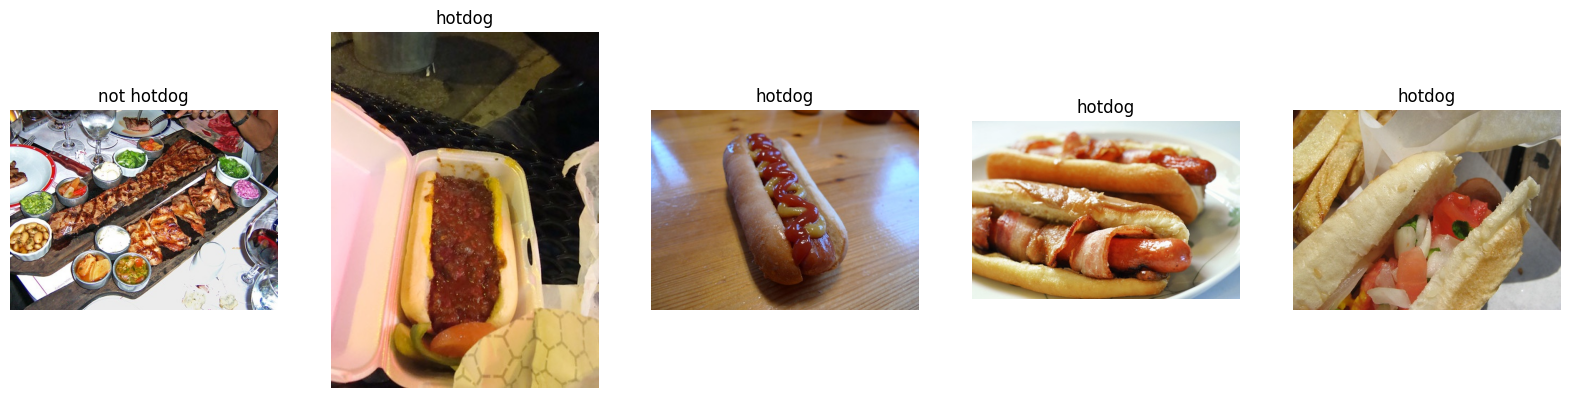

In [50]:
show_images(raw_trainset, 5)
show_images(raw_evalset, 5)

In [51]:
# load dataset and build DataLoader

def build_loaders(
    data_path: str,
    train_transform,
    eval_transform,
    batch_size: int = 64,
    num_workers: int = 4,
) -> Tuple[DataLoader, DataLoader, list]:

    trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path=data_path)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testset = Hotdog_NotHotdog(train=False, transform=eval_transform, data_path=data_path)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader, trainset.image_classes

In [52]:
def build_model(num_classes: int, device: torch.device) -> nn.Module:
    model = models.resnet18(weights=None)  # <- from scratch
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def build_pretrained_model(num_classes: int, device: torch.device, freeze_backbone: bool = True) -> nn.Module:
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    if freeze_backbone:
        for name, p in model.named_parameters():
            if not name.startswith('fc'):
                p.requires_grad = False
    return model.to(device)

In [53]:
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device, criterion) -> Tuple[float, float]:
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_count += x.size(0)
    return total_loss / total_count, total_correct / total_count

In [55]:
def train_one_epoch(model, loader, device, optimizer, criterion, epoch, epochs) -> Tuple[float, float]:
    model.train()
    total_loss, total_correct, total_count = 0.0, 0, 0

    pbar = tqdm(loader, desc=f"Epoch {epoch}/{epochs} [train]", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device.type, enabled=(device.type in ["cuda", "mps"])):
            logits = model(x)
            loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_count += x.size(0)

        # live batch metrics on the bar
        pbar.set_postfix(loss=f"{total_loss/total_count:.4f}", acc=f"{(total_correct/total_count)*100:.2f}%")

    return total_loss / total_count, total_correct / total_count

In [57]:
def get_optimizer(optimizer_name, model_parameters, lr=0.001, weight_decay=1e-4):
    """
    Return a PyTorch optimizer based on the given name.

    Args:
        optimizer_name (str): Name of the optimizer. Options:
            'sgd', 'sgd_with_weight_decay', 'adam', 'adamw', 'adadelta'
        model_parameters: model.parameters()
        lr (float): learning rate
        weight_decay (float): weight decay (L2 regularization)

    Returns:
        optimizer: PyTorch optimizer object
    """
    optimizer_name = optimizer_name.lower()

    if optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model_parameters, lr=lr, momentum=0.9, nesterov=True)
    elif optimizer_name == 'sgd_with_weight_decay':
        optimizer = torch.optim.SGD(model_parameters, lr=lr, momentum=0.9, weight_decay=weight_decay, nesterov=True)
    elif optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model_parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'adamw':
        optimizer = torch.optim.AdamW(model_parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'adadelta':
        optimizer = torch.optim.Adadelta(model_parameters, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    return optimizer



In [58]:
def run_config(
    data_path: str,
    train_tfms: Dict[str, object],
    eval_tfms,
    cfg_key: str,
    epochs: int = 30,
    batch_size: int = 64,
    optimizer_name: str = "sgd",
    lr: float = 3e-4,
    weight_decay: float = 0.0005,
    label_smoothing: float = 0.05,
    seed: int = 42,
    use_pretrained: bool = False,
    freeze_backbone: bool = True,
):
    assert cfg_key in train_tfms, f"Unknown transform config: {cfg_key}"

    device = get_device()
    print(f"[Device] {device} | [Config] {cfg_key} | [Seed] {seed}")

    # Data
    train_loader, val_loader, classes = build_loaders(
        data_path=data_path,
        train_transform=train_tfms[cfg_key],
        eval_transform=eval_tfms,
        batch_size=batch_size,
        num_workers=num_workers,
    )

    # Model / Opt / Sched / Loss
    if use_pretrained:
        model = build_pretrained_model(num_classes=len(classes), device=device, freeze_backbone=freeze_backbone)
    else:
        model = build_model(num_classes=len(classes), device=device)
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr=lr, weight_decay=weight_decay)
    # Cosine schedule without restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    best_val_acc, best_state = 0.0, None
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, device, optimizer, criterion, ep, epochs)
        val_loss, val_acc = evaluate(model, val_loader, device, criterion)
        scheduler.step()

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(scheduler.get_last_lr()[0])

        print(f"Epoch {ep:02d}/{epochs} | "
              f"Train: loss {tr_loss:.4f}, acc {tr_acc*100:5.2f}% | "
              f"Val: loss {val_loss:.4f}, acc {val_acc*100:5.2f}% | "
              f"lr={scheduler.get_last_lr()[0]:.2e}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    # Save best checkpoint
    out_dir = Path("checkpoints"); out_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = out_dir / f"resnet18_scratch_{cfg_key}_seed{seed}.pt"
    torch.save({"state_dict": best_state, "classes": classes, "config": cfg_key}, ckpt_path)
    print(f"[Saved] {ckpt_path} (best val acc = {best_val_acc*100:.2f}%)")


    return best_val_acc, history, str(ckpt_path), model, val_loader

In [56]:
# plot acc/loss curves
def plot_curves(epochs: int, history: Dict[str, list]):
    # Plot curves
    epochs_axis = range(1, epochs + 1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_axis, history["train_loss"], label="train")
    plt.plot(epochs_axis, history["val_loss"], label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_axis, [a*100 for a in history["train_acc"]], label="train")
    plt.plot(epochs_axis, [a*100 for a in history["val_acc"]], label="val")
    plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.title("Accuracy"); plt.legend()
    plt.tight_layout()
    plt.show()

In [54]:
# plot misclassified images
def show_misclassified(model, loader, class_names=['hotdog','not hotdog'], device='cuda', max_images=20):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Find indices where prediction != label
            wrong_idx = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in wrong_idx:
                misclassified.append((images[idx].cpu(), labels[idx].cpu(), preds[idx].cpu()))
                if len(misclassified) >= max_images:
                    break
            if len(misclassified) >= max_images:
                break

    # Plot misclassified images
    plt.figure(figsize=(20,10))
    for i, (img, label, pred) in enumerate(misclassified):
        plt.subplot(4, 5, i+1)
        img_np = img.permute(1,2,0).numpy()  # CHW -> HWC
        plt.imshow(img_np)
        plt.title(f'True: {class_names[label]} | Pred: {class_names[pred]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return misclassified

In [61]:
# start to train


best_acc, hist, ckpt, model, val_loader = run_config(
    data_path=data_path,
    train_tfms=train_tfms,
    eval_tfms=eval_tfms,
    cfg_key="Baseline",
    epochs=epochs,
    batch_size=batch_size,
    optimizer_name = "sgd",
    lr=0.0005,
    weight_decay = 0.0005,
    label_smoothing=0.05,
    seed=42,
    use_pretrained=False,
    freeze_backbone=True,
)

[Device] cuda | [Config] Baseline | [Seed] 42


Epoch 1/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 01/20 | Train: loss 0.6643, acc 59.75% | Val: loss 0.6759, acc 57.79% | lr=4.97e-04


Epoch 2/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 02/20 | Train: loss 0.6247, acc 66.24% | Val: loss 0.6355, acc 63.80% | lr=4.88e-04


Epoch 3/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 03/20 | Train: loss 0.6060, acc 68.64% | Val: loss 0.6220, acc 65.95% | lr=4.73e-04


Epoch 4/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 04/20 | Train: loss 0.5930, acc 70.79% | Val: loss 0.5939, acc 70.19% | lr=4.52e-04


Epoch 5/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 05/20 | Train: loss 0.5703, acc 72.84% | Val: loss 0.5983, acc 69.39% | lr=4.27e-04


Epoch 6/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 06/20 | Train: loss 0.5545, acc 73.91% | Val: loss 0.5841, acc 71.86% | lr=3.97e-04


Epoch 7/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 07/20 | Train: loss 0.5363, acc 76.16% | Val: loss 0.5941, acc 70.19% | lr=3.63e-04


Epoch 8/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 08/20 | Train: loss 0.5249, acc 77.38% | Val: loss 0.5645, acc 73.74% | lr=3.27e-04


Epoch 9/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 09/20 | Train: loss 0.5135, acc 78.26% | Val: loss 0.5706, acc 72.56% | lr=2.89e-04


Epoch 10/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/20 | Train: loss 0.4970, acc 79.43% | Val: loss 0.5573, acc 74.44% | lr=2.50e-04


Epoch 11/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/20 | Train: loss 0.4858, acc 79.09% | Val: loss 0.5499, acc 75.03% | lr=2.11e-04


Epoch 12/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/20 | Train: loss 0.4757, acc 80.75% | Val: loss 0.5624, acc 73.85% | lr=1.73e-04


Epoch 13/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/20 | Train: loss 0.4653, acc 81.34% | Val: loss 0.5434, acc 75.30% | lr=1.37e-04


Epoch 14/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/20 | Train: loss 0.4568, acc 81.39% | Val: loss 0.5517, acc 74.60% | lr=1.03e-04


Epoch 15/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/20 | Train: loss 0.4558, acc 82.22% | Val: loss 0.5377, acc 75.35% | lr=7.32e-05


Epoch 16/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/20 | Train: loss 0.4492, acc 82.61% | Val: loss 0.5340, acc 75.51% | lr=4.77e-05


Epoch 17/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/20 | Train: loss 0.4430, acc 83.29% | Val: loss 0.5360, acc 75.40% | lr=2.72e-05


Epoch 18/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/20 | Train: loss 0.4386, acc 83.00% | Val: loss 0.5396, acc 74.97% | lr=1.22e-05


Epoch 19/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/20 | Train: loss 0.4444, acc 82.46% | Val: loss 0.5376, acc 75.19% | lr=3.08e-06


Epoch 20/20 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/20 | Train: loss 0.4406, acc 82.95% | Val: loss 0.5367, acc 75.08% | lr=0.00e+00
[Saved] checkpoints/resnet18_scratch_Baseline_seed42.pt (best val acc = 75.51%)


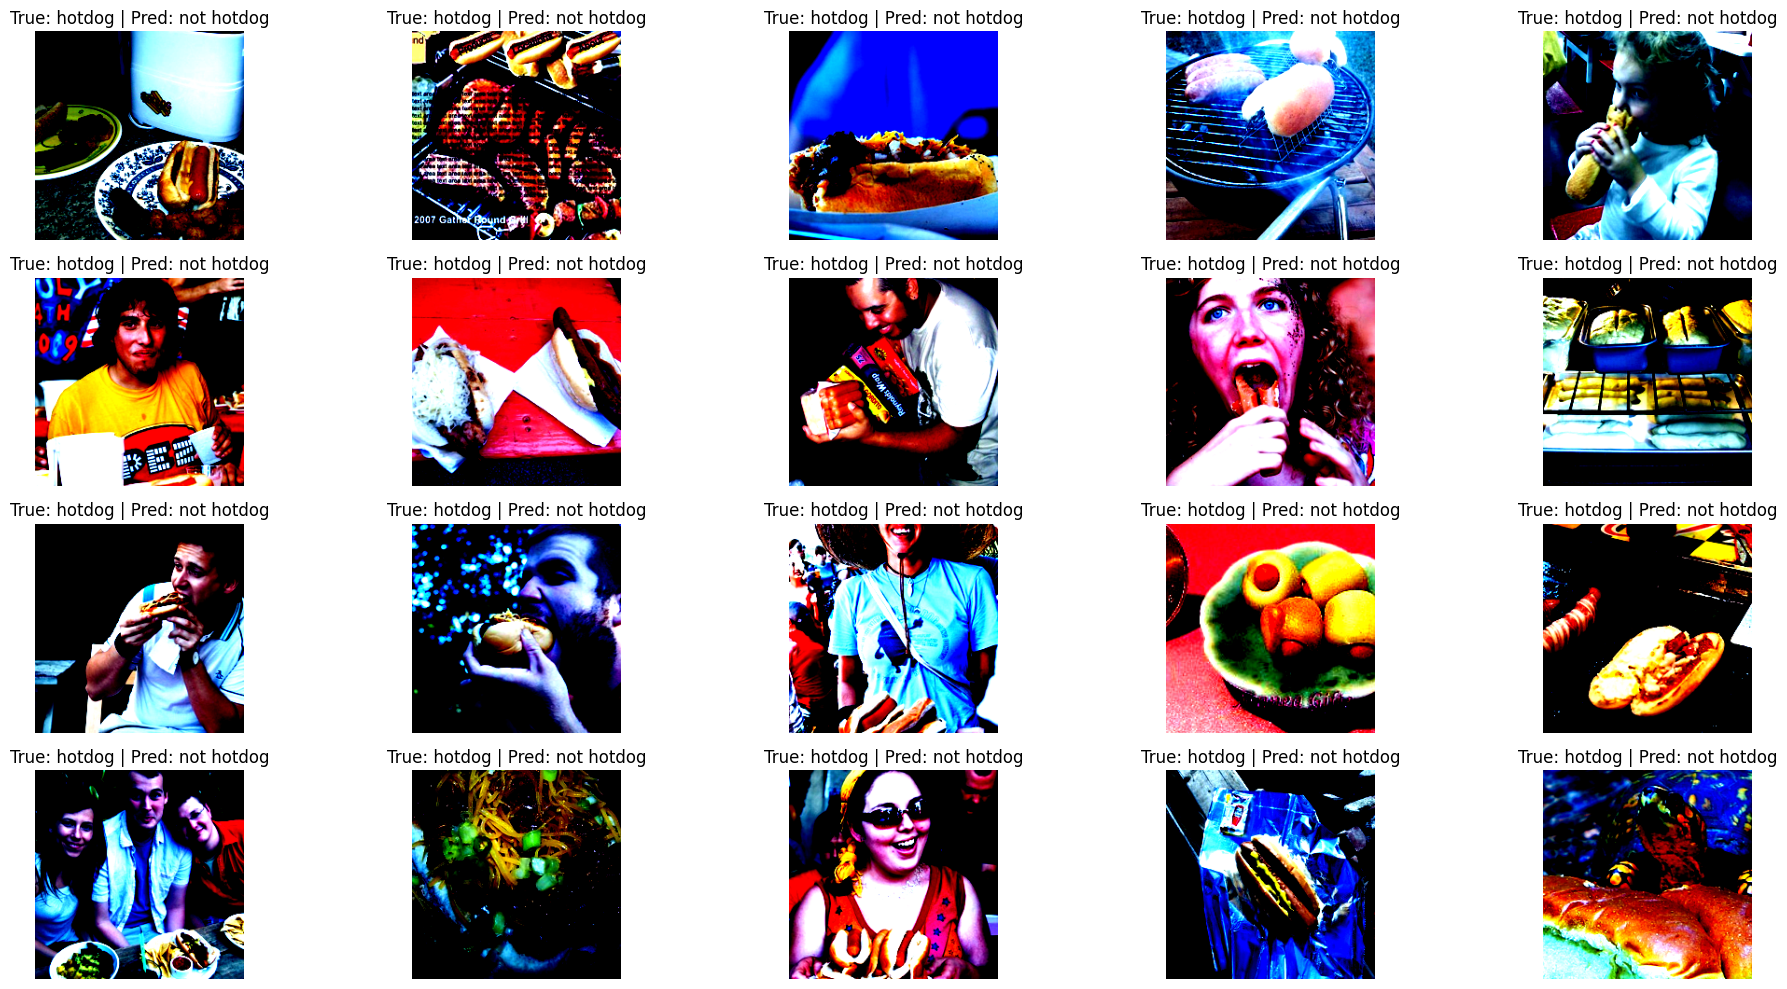

In [62]:
misclassified_images = show_misclassified(model, val_loader, class_names=['hotdog','not hotdog'], device=get_device(), max_images=20)

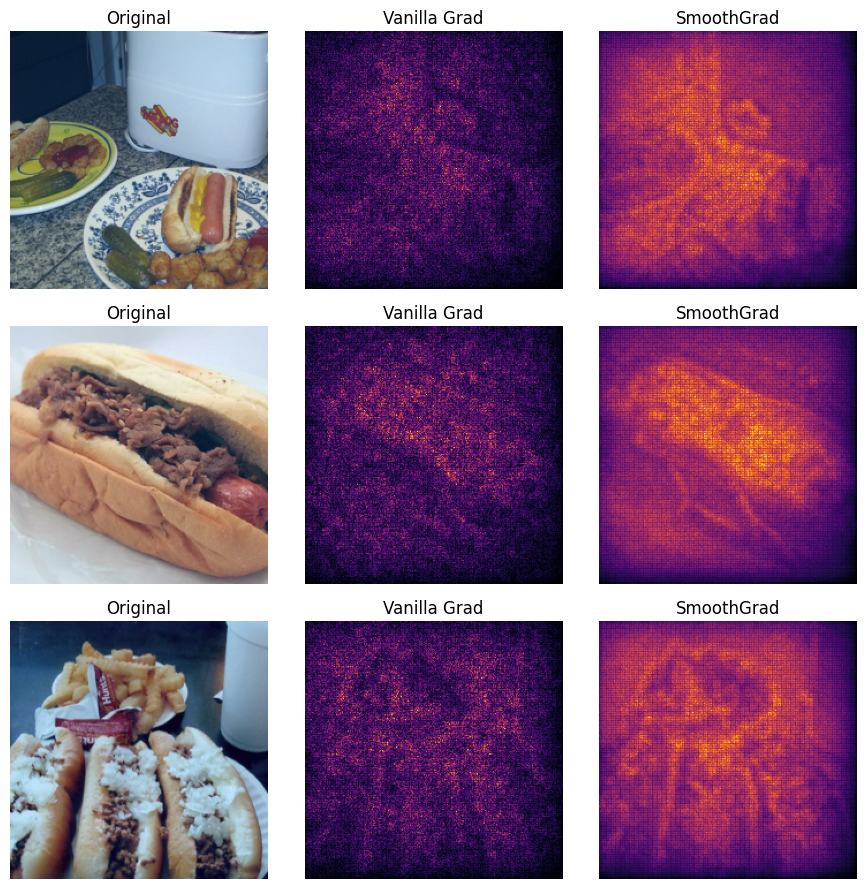

In [63]:
plot_smoothgrad_saliency_map(model, val_loader, device=device, n_samples=25, noise_std=0.15, k=3)

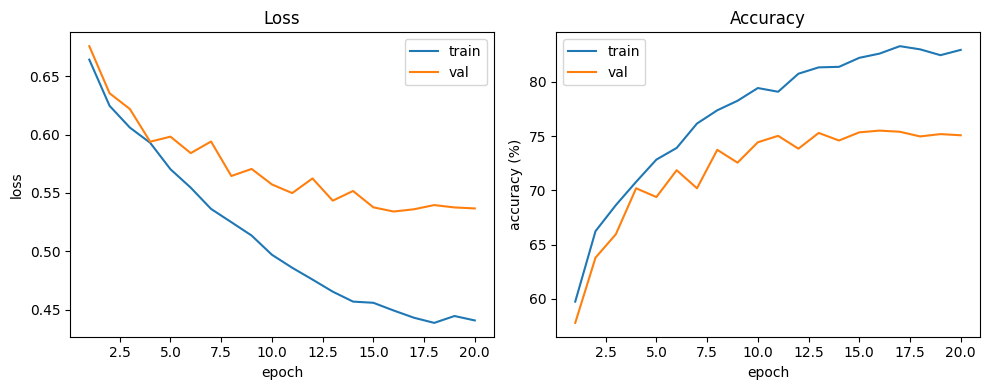

In [64]:
plot_curves(20, hist)